In [1]:
!pip install ns3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.6/206.6 kB 22.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached cppyy_backend-1.14.10-py2.py3-none-linux_x86_64.whl
  Using cached cppyy_cling-6.27.1-py2.py3-none-manylinux2014_x86_64.whl (32.4 MB)
  Created wheel for cppyy: filename=cppyy-2.4.2-py3-none-any.whl size=15352142 sha256=de5e97bc17214d21ad685d989d08c4b49148574732c146798fc33fbddc385e66
  Stored in directory: /root/.cache/pip/wheels/73/66/49/38da85078450bb1a5b63405aec0935de2e2991717394ac2f64
  Created wheel for CPyCppyy: filename=CPyCppyy-1.12.12-cp310-cp310-linux_x86_64.whl size=4182309 sha256=528c38c5b9b7

In [2]:
from ns import ns
from matplotlib import pyplot as plt

In [3]:

# Get the coordinates for each node in the NodeContainer and plot
def plotNodePosition(nodeContainer : ns.NodeContainer, showLegend: bool = True) -> None:
    for node_i in range(nodeContainer.GetN()):
        node = nodeContainer.Get(node_i).__deref__()
        mobility = node.GetObject[ns.MobilityModel]().__deref__()
        position = mobility.GetPosition()
        plt.scatter((position.x), (position.y), label=f"Node {node.GetId()}")
    plt.ylabel("Y (m)")
    plt.xlabel("X (m)")
    if showLegend:
        plt.legend()
    plt.show()

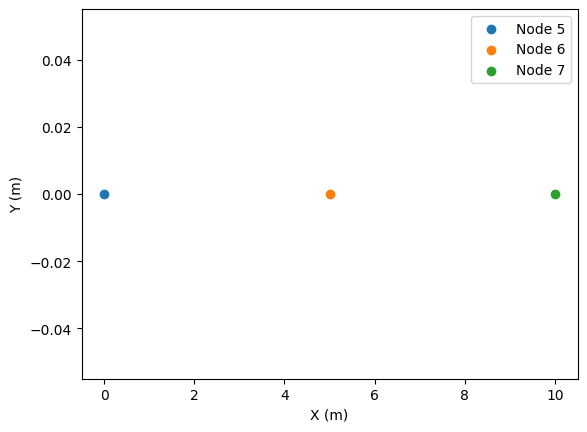

In [4]:
# // Default Network Topology
# //
# //   Wifi 10.1.3.0
# //                 AP
# //  *    *    *    *
# //  |    |    |    |    10.1.1.0
# // n5   n6   n7   n0 -------------- n1   n2   n3   n4
# //                   point-to-point  |    |    |    |
# //                                   ================
# //                                     LAN 10.1.2.0

nCsma = 3
verbose = True
nWifi = 3
tracing = False

p2pNodes = ns.network.NodeContainer()
p2pNodes.Create(2)

pointToPoint = ns.point_to_point.PointToPointHelper()
pointToPoint.SetDeviceAttribute("DataRate", ns.core.StringValue("5Mbps"))
pointToPoint.SetChannelAttribute("Delay", ns.core.StringValue("2ms"))

p2pDevices = pointToPoint.Install(p2pNodes)

csmaNodes = ns.network.NodeContainer()
csmaNodes.Add(p2pNodes.Get(1))
csmaNodes.Create(nCsma)

csma = ns.csma.CsmaHelper()
csma.SetChannelAttribute("DataRate", ns.core.StringValue("100Mbps"))
csma.SetChannelAttribute("Delay", ns.core.TimeValue(ns.core.NanoSeconds(6560)))

csmaDevices = csma.Install(csmaNodes)

wifiStaNodes = ns.network.NodeContainer()
wifiStaNodes.Create(nWifi)
wifiApNode = p2pNodes.Get(0)

channel = ns.wifi.YansWifiChannelHelper.Default()
phy = ns.wifi.YansWifiPhyHelper()
phy.SetChannel(channel.Create())

mac = ns.wifi.WifiMacHelper()
ssid = ns.wifi.Ssid ("ns-3-ssid")

wifi = ns.wifi.WifiHelper()

mac.SetType ("ns3::StaWifiMac", "Ssid", ns.wifi.SsidValue(ssid), "ActiveProbing", ns.core.BooleanValue(False))
staDevices = wifi.Install(phy, mac, wifiStaNodes)

mac.SetType("ns3::ApWifiMac","Ssid", ns.wifi.SsidValue (ssid))
apDevices = wifi.Install(phy, mac, wifiApNode)

mobility = ns.mobility.MobilityHelper()
mobility.SetPositionAllocator ("ns3::GridPositionAllocator", "MinX", ns.core.DoubleValue(0.0),
								"MinY", ns.core.DoubleValue (0.0), "DeltaX", ns.core.DoubleValue(5.0), "DeltaY", ns.core.DoubleValue(10.0),
                                 "GridWidth", ns.core.UintegerValue(3), "LayoutType", ns.core.StringValue("RowFirst"))

mobility.SetMobilityModel ("ns3::RandomWalk2dMobilityModel", "Bounds", ns.mobility.RectangleValue(ns.mobility.Rectangle (-50, 50, -50, 50)))
mobility.Install(wifiStaNodes)

mobility.SetMobilityModel("ns3::ConstantPositionMobilityModel")
mobility.Install(wifiApNode)

plotNodePosition(wifiStaNodes)

stack = ns.internet.InternetStackHelper()
stack.Install(csmaNodes)
stack.Install(wifiApNode)
stack.Install(wifiStaNodes)

address = ns.internet.Ipv4AddressHelper()
address.SetBase(ns.network.Ipv4Address("10.1.1.0"), ns.network.Ipv4Mask("255.255.255.0"))
p2pInterfaces = address.Assign(p2pDevices)

address.SetBase(ns.network.Ipv4Address("10.1.2.0"), ns.network.Ipv4Mask("255.255.255.0"))
csmaInterfaces = address.Assign(csmaDevices)

address.SetBase(ns.network.Ipv4Address("10.1.3.0"), ns.network.Ipv4Mask("255.255.255.0"))
address.Assign(staDevices)
address.Assign(apDevices)

echoServer = ns.applications.UdpEchoServerHelper(9)

serverApps = echoServer.Install(csmaNodes.Get(nCsma))
serverApps.Start(ns.core.Seconds(1.0))
serverApps.Stop(ns.core.Seconds(10.0))

echoClient = ns.applications.UdpEchoClientHelper(csmaInterfaces.GetAddress(nCsma).ConvertTo(), 9)
echoClient.SetAttribute("MaxPackets", ns.core.UintegerValue(1))
echoClient.SetAttribute("Interval", ns.core.TimeValue(ns.core.Seconds (1.0)))
echoClient.SetAttribute("PacketSize", ns.core.UintegerValue(1024))

clientApps = echoClient.Install(wifiStaNodes.Get (nWifi - 1))
clientApps.Start(ns.core.Seconds(2.0))
clientApps.Stop(ns.core.Seconds(10.0))

ns.internet.Ipv4GlobalRoutingHelper.PopulateRoutingTables()

ns.core.Simulator.Stop(ns.core.Seconds(10.0))

pointToPoint.EnablePcapAll ("third")
phy.EnablePcap ("third", apDevices.Get (0))
csma.EnablePcap ("third", csmaDevices.Get (0), True)

ns.core.Simulator.Run()
ns.core.Simulator.Destroy()
